## Overview

The purpose of this notebook is to improve the performance of the baseline model by creating derived features for the Naive Bayes classifier. Since the BernoulliNB classifier can only handle categorial attributes, we'll derive categorical features from numeric ones and bin some of the informative attributes using feature selection to identify the best binning strategy.

### Existing Features

#### Categorical Attributes
* Most categorical attributes are informative of the outcome of the marketing campaign except for `marital` and `day_of_week`
* Several attributes contain missing values but there are not any a-priori reasons to treat the missing values differently from regular values.  
* An additional indicator that encodes whether a customer was contacted prior to the current campaign may improve predictive performance as `poutcome` values of 'success' and 'failure' have higher response rates than the 'nonexistent' value

#### Numeric Attributes
* `age` outliers include people over the age of ~62
    * Accross all ages, customers who were contacted more than ten times were not likely to respond to the campaign
    * Younger and older customers tend to convert more than middle-aged customers
* `pdays` uses a very large number (999) to encode missing values.  Non-missing instances are seven times more likely to convert than missing instances
* `previous` values are finite - can be converted to a categorical variable / binned
* Socioeconomic distributions are sparse
* Strong correlation between
    * `emp.var.rate` and `cons.price.idx`
    * `emp.var.rate` and `euribor3m`
    * `emp.var.rate` and `nr.employed`
    * `nr.employed` and `euribor3m`


### New Features
* Create an indicator of whether a customer was previously contacted as part of a previous campaign (`pdays`)
* Create an indicator of whether a customer was part of a previous campaign (`poutcome`)
* Transform `previous` to a categorical variable
* Apply binning to:
    * log(`age`)
    * `campaign`

In [89]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import clone
from utils import code

import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
bank = pd.read_csv('../data/train.csv')
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,25,blue-collar,single,high.school,no,yes,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
1,40,admin.,married,high.school,no,no,no,telephone,jun,thu,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.958,5228.1,no
2,51,technician,married,university.degree,no,yes,no,cellular,aug,wed,...,5,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,yes
3,37,blue-collar,married,high.school,unknown,yes,no,cellular,jul,tue,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no
4,54,housemaid,married,university.degree,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no


In [3]:
X = bank.drop('y', axis=1)
y = bank.y

## Computations

### Was the customer contacted about the last campaign?

In [7]:
def ft_pcontacted_last_campaign(X):
  pcontacted = ~(X == 999)
  return pcontacted.values.reshape(-1,1)

In [8]:
add_pcontacted_last_campaign = FunctionTransformer(ft_pcontacted_last_campaign, validate=False)
add_pcontacted_last_campaign_ct = ColumnTransformer([('add_pcontacted', add_pcontacted_last_campaign, 'pdays')])

pcontacted_last_campaign = add_pcontacted_last_campaign_ct.fit_transform(X)

# Make sure the resulting values are correct
all(X.loc[np.where(pcontacted_last_campaign.ravel() == True)[0], ['pdays']] == '999')

True

### Was the customer part of the last campaign?

In [9]:
def ft_pcampaign(X):
  pcampaign = ~(X == 'nonexistent')
  return pcampaign.values.reshape(-1,1)

In [10]:
add_pcampaign = FunctionTransformer(ft_pcampaign, validate=False)
add_pcampaign_ct = ColumnTransformer([('add_poutcome', add_pcampaign, 'poutcome')])

pcampaign = add_pcampaign_ct.fit_transform(X)

# Make sure the resulting values are correct
all(X.loc[np.where(pcampaign.ravel() == True)[0], ['poutcome']] != 'nonexistent')

True

### Was the customer contacted more than ten times?

In [11]:
def ft_campaign_gte10(X):
  campaign_gte10 = X >= 10
  return campaign_gte10.values.reshape(-1,1)

In [12]:
add_campaign_gte10 = FunctionTransformer(ft_campaign_gte10, validate=False)
add_campaign_gte10_ct = ColumnTransformer([('campaign_gte10', add_campaign_gte10, 'campaign')])

campaign_gte10 = add_campaign_gte10_ct.fit_transform(X)

# Make sure the resulting values are correct
all(X.loc[np.where(campaign_gte10.ravel() == True)[0], ['campaign']] >= 10)

True

### Transform previous to categorical

In [13]:
def ft_previous(X):
  previous = X.astype(str)
  return previous.values.reshape(-1,1)

In [14]:
add_previous = FunctionTransformer(ft_previous, validate=False)
add_previous_ct = ColumnTransformer([('add_previous', add_previous, 'previous')])

previous = add_previous_ct.fit_transform(X)

# Make sure the resulting values are correct
all(previous.astype(int).ravel() == X.previous)

True

### Apply binning as a hyperparameter

Apply a log transform to `age` to transform the distribution

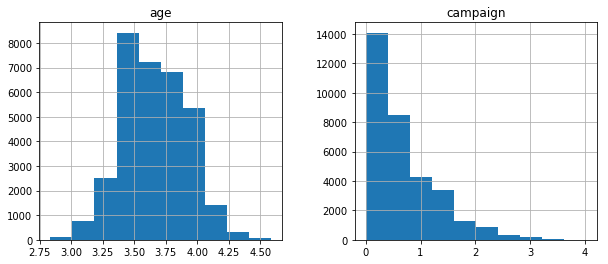

In [30]:
np.log(X[['age', 'campaign']]).hist(figsize=(10,4));

In [69]:
binning_pipeline = Pipeline([
  ('log', FunctionTransformer(np.log, validate=True)),
  ('kbins', KBinsDiscretizer())
])

age_campaign_ct = ColumnTransformer([
  ('age_pipeline', clone(binning_pipeline), ['age']),
  ('campaign_pipeline', clone(binning_pipeline), ['campaign'])
])
age_campaign_ct.fit_transform(X)

<32950x10 sparse matrix of type '<class 'numpy.float64'>'
	with 65900 stored elements in Compressed Sparse Row format>

Apply a log transform to `campaign` to transform the distribution

## Pipeline

* Apply column transformers (categorical)
* Apply column transformers (numeric)

In [70]:
# Create the transformers for categorical features
new_cat_features = [
  ('pcontacted_last_campaign', add_pcontacted_last_campaign, 'pdays'),
  ('poutcome', add_pcampaign, 'poutcome'),
  ('previous', add_previous, 'previous'),
  ('campaign_gte10', add_campaign_gte10, 'campaign')
]
cat_ct = ColumnTransformer(new_cat_features)

# Create the pipeline to transform categorical features
cat_pipeline = Pipeline([
  ('cat_ct', cat_ct),
  ('ohe', OneHotEncoder(handle_unknown='ignore'))
])
cat_pipeline.fit(X)

Pipeline(memory=None,
     steps=[('cat_ct', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('pcontacted_last_campaign', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function ft_pcontacted_last_campaign at 0x1a1ad...
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True))])

In [71]:
cat_ct.fit_transform(X).shape

(32950, 4)

In [72]:
# Create the feature union of categorical and numeric attributes
ft_union = FeatureUnion([
  ('cat_pipeline', cat_pipeline),
  ('num_pipeline', age_campaign_ct)
])

ft_union.fit(X)
features = ft_union.transform(X)
features.shape

(32950, 24)

Create categorical feature names post-transformation

In [75]:
# Add column names
feature_names = [
  # Don't incclude the last entry in the `named_transformers_` list since
  # it's the `remainder` parameter for the ColumnTransformer
  ['%s_%s' % (name, value) for value in values] for 
    name, values in list(zip(list(cat_ct.named_transformers_.keys())[1:], cat_pipeline.named_steps['ohe'].categories_))]

cat_feature_names = [name for names in feature_names for name in names]
cat_feature_names

['pcontacted_last_campaign_False',
 'pcontacted_last_campaign_True',
 'previous_False',
 'previous_True',
 'poutcome_0',
 'poutcome_1',
 'poutcome_2',
 'poutcome_3',
 'poutcome_4',
 'poutcome_5',
 'poutcome_6',
 'poutcome_7',
 'campaign_gte10_False',
 'campaign_gte10_True']

Create numeric feature names post-transformation

In [87]:
# TODO

# numeric_feature_names = age_campaign_ct.transformers_[0][2]
# p = age_campaign_ct.named_transformers_['age_pipeline']
# p2 = p.named_steps['kbins']
# p2.n_bins_

In [85]:
# features_df = pd.DataFrame(features.todense(), columns=cat_feature_names + numeric_feature_names)
# features_df.head()

Try the file we created as code

In [90]:
%load_ext autoreload
%autoreload 2

from support.experiments import experiment_2

In [94]:
pipeline = experiment_2.get_pipeline()
assert features.shape == pipeline.fit_transform(X).shape